In [1]:
from db import Database
import processing as proc
import matplotlib.pyplot as plt
records = Database("bank_data")
smallerTable = "people"
largerTable = "people_additional"
print(records.getEntries('people',0,1))
print(records.getSize("people"))
"""
TABLE people (
id INT AUTO_INCREMENT,
age TINYINT,
job CHAR(1),
maritial CHAR(1),
education CHAR(1),
isDefault CHAR(1),
balance INT,
housing CHAR(1),
loan CHAR(1),
contact CHAR(1),
day TINYINT,
month TINYINT,
duration SMALLINT,
campaign TINYINT,
pdays SMALLINT,
previous SMALLINT,
poutcome CHAR(1),
y CHAR(1),
"""

Connected to db
Successful SQL commands are printed on execution.
USE bank_data
[(1, 58, 'M', 'M', 'T', 'N', 2143, 'Y', 'N', '?', 5, 5, 261, 1, -1, 0, '?', 'N')]
45211


'\nTABLE people (\nid INT AUTO_INCREMENT,\nage TINYINT,\njob CHAR(1),\nmaritial CHAR(1),\neducation CHAR(1),\nisDefault CHAR(1),\nbalance INT,\nhousing CHAR(1),\nloan CHAR(1),\ncontact CHAR(1),\nday TINYINT,\nmonth TINYINT,\nduration SMALLINT,\ncampaign TINYINT,\npdays SMALLINT,\nprevious SMALLINT,\npoutcome CHAR(1),\ny CHAR(1),\n'

In [2]:
#first just examine frequency of 'y'
numPeople = records.getSize('people')
numPeopleAdditional = records.getSize('people_additional')
peopleOut = records.getEntriesByField('people',0,numPeople,'y')
peopleAdditionalOut = records.getEntriesByField('people_additional',0,numPeopleAdditional,'y')

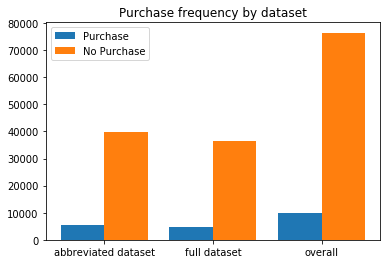

In the abbreviated dataset a purchase occured 11.70% of the time.
In the full dataset a purchase occured 11.27% of the time.
In the combined dataset a purchase occured 11.49% of the time.


In [3]:
#print out buying frequency
peopleBuy = 0

for char in peopleOut:
    if char == 'Y': peopleBuy+=1
peopleAdditionalBuy = 0
for char in peopleAdditionalOut:
    if char == 'Y': peopleAdditionalBuy+=1

buys = (peopleBuy,peopleAdditionalBuy,peopleBuy+peopleAdditionalBuy)
notBuys = (numPeople-buys[0],numPeopleAdditional-buys[1],numPeople+numPeopleAdditional-buys[2])

ind = [ i for i in range(3)]
width = .4
plt.figure(1)
plt.bar(ind,buys,width,label= 'Purchase')
plt.bar([item+width for item in ind],notBuys,width,label='No Purchase')
plt.title('Purchase frequency by dataset')
plt.xticks([item+width/2 for item in ind],('abbreviated dataset','full dataset', 'overall'))
plt.legend(loc='best')
plt.show()

print("In the abbreviated dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[0])/float(numPeople) )*100 ) )
print("In the full dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[1])/float(numPeopleAdditional) )*100 ) )
print("In the combined dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[2])/float(numPeople+numPeopleAdditional) )*100 ) )


In [4]:
#get data dictionaries for processing
peopleMap, peopleAdditionalMap = records.getMaps()

#get processing vectors, used to turn catagorical data to one-hot
procPeople,procAdditional = proc.generateProcMaps(peopleMap,peopleAdditionalMap)

#generate labels for one-hot
labelsPeople,labelsPeopleAdditional = proc.generateLabels(peopleMap,peopleAdditionalMap)

#length of final one-hot processing vectors
peopleLen = procPeople[-1]
additionalLen = procAdditional[-1]








{'age': 0, 'job': {'M': 'management', 'B': 'blue-collar', 'E': 'entrepreneur', 'H': 'housemaid', 'R': 'retired', 'F': 'self-employed', 'V': 'services', 'S': 'student', 'T': 'technician', 'U': 'unemployed', '?': 'unknown'}, 'marital': {'D': 'divorced', 'M': 'married', 'S': 'single', '?': 'unknown'}, 'education': {'P': 'primary', 'S': 'secondary', 'T': 'tertiary', '?': 'unknown'}, 'isDefault': {'Y': 'yes', 'N': 'no', '?': 'unknown'}, 'balance': 2, 'housing': {'Y': 'yes', 'N': 'no', '?': 'unknown'}, 'loan': {'Y': 'yes', 'N': 'no', '?': 'unknown'}, 'contact': {'C': 'cellular', 'T': 'telephone', '?': 'unknown'}, 'day': 0, 'month': {1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct', 11: 'nov', 12: 'dec'}, 'duration': 1, 'campaign': 0, 'pdays': 1, 'previous': 1, 'poutcome': {'S': 'success', 'F': 'failure', 'O': 'other', '?': 'unknown'}, 'y': {'Y': 'yes', 'N': 'no'}}
+++++++++++++++++++
age
job:management
job:blue-collar
job:entrepreneur
job:ho